In [9]:
# 파이썬≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [10]:
# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
	path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
	print("그림 저장:", fig_id)
	if tight_layout:
		plt.tight_layout()
	plt.savefig(path, format=fig_extension, dpi=resolution)

from matplotlib import font_manager, rc
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
	rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
	font_name = font_manager.FontProperties(fname=path).get_name()
	rc('font', family=font_name)

In [11]:
mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3

import seaborn as sns
import scipy as sp
from scipy import stats
# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"
# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# classification
## Minist Data

In [13]:
# 데이터 다운로드
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784',version=1,as_frame=False)
print(mnist.keys())

/Users/kimjimin/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [17]:
X,y=mnist['data'],mnist['target']
print(X.shape)
# 데이터는 784 픽셀을 가진 흑백 이미지, 실제 크기 28*28
# 각 픽셀은 0~255 까지의 값.. 
print(y.shape)

(70000, 784)
(70000,)


(-0.500, 27.500, 27.500, -0.500)

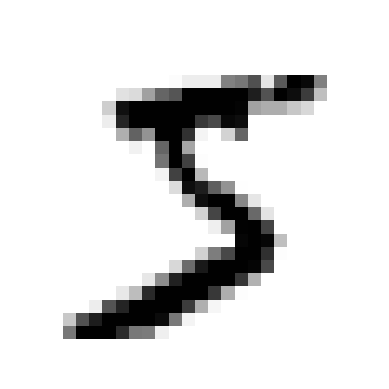

In [19]:
# 하나의 이미지 출력
some_digit=X[0] # 이 이미지는 784 픽셀로 구성. 
some_digit_image=some_digit.reshape(28,28) # 흑백 이미지를 2차원 이미지로 변환
plt.imshow(some_digit_image,cmap=mpl.cm.binary) # 검은색에서 흰색까지의 색상들
plt.axis('off')

In [21]:
# 출력한 이미지의 레이블을 확인
print(y[0])

5


그림 저장: more_digits_plot


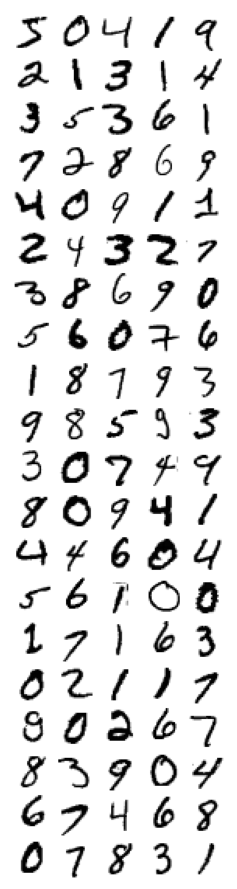

In [22]:
# 여러개의 이미지를 출력하기 위한 함수
# 첫번째 매개변수 - 이미지들, 두번쨰 매개변수 - 하나의 행에 출력할 이미지수( 기본값 10 )
# 세번째 매개변수 - 옵션으로 딕셔너리를 설정. 
# 여러개의 옵션을 설정해야하는 경우 각 매개변수를 나열하는 것은 함수의 가독성을 떨어뜨림.
# 이런 경우 매개변수를 하나로 묶어야 하는데 dict 나 class 가 된다. 
# 생략이 가능한 옵션을 많이 가지고 있다 -> dict, 그렇지 않으면 class 사용.

def plot_digits(instances,images_per_row=10,**options):
    # 이미지 크기 변수로 생성
	size=28
	# 행에 출력할 이미지의 개수
	images_per_row=min(len(instances),images_per_row) # 행에 출력할게 행의 수보다 적으면 그만큼만 출력함
	# 이미지 크기 설정
	images=[instance.reshape(size,size) for instance in instances]
	# 행의 개수 출력
	n_rows=(len(instances)-1)//images_per_row+1 # 몫을 구한다.
	# 이미지 저장할 리스트
	row_images=[]
	n_empty = n_rows * images_per_row - len(instances)
    #0으로 가득채운 행렬을 만들어서 images 에 저장
	images.append(np.zeros((size, size * n_empty)))
    #행 단위로 순회하면서 이미지를 추가
	for row in range(n_rows):
		rimages = images[row * images_per_row : (row + 1) * images_per_row] # 행의 시작 부터 그 다음 행의 전 ( 해당 행의 마지막 데이터까지 의 데이터를 가져옴. )
		row_images.append(np.concatenate(rimages, axis=1))
	image = np.concatenate(row_images, axis=0)
	#이미지 출력
	plt.imshow(image, cmap = mpl.cm.binary, **options)
	plt.axis("off")


plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=5)
plt.show()

In [24]:
# 타겟의 자료형 확인
print(type(y[0]))
# 범주형 데이터의 자료형은 정수를 권장한다.
y=y.astype(np.uint8)
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


## 이진 분류를 위한 데이터 생성

In [25]:
# 훈련 데이터와 테스트 데이터 분리
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

# 이진 분류의 경우 타겟 값이 2개. 

# 5인지 아닌지 판별하기 위한 데이터. 
y_train_5=(y_train==5)
y_test_5=(y_test==5)
print(y_train_5[0])


True


## sklearn SGDClassifier ( Stochastic Gradient Descent - 확률적 경사 하강법 ) 클래스

### 훈련 및 데이터 예측

In [30]:
from sklearn.linear_model import SGDClassifier

# 훈련에 사용할 모델을 생성 - 하이퍼파라미터 설정
# max_iter는 최대 반복 횟수
# tol은 정밀도
sgd_clf=SGDClassifier(max_iter=1000,tol=1e-3,random_state=42)

# 훈련
sgd_clf.fit(X_train,y_train_5)

# 예측
sgd_clf.predict([some_digit]) # feature 는 2차원 배열 이상이어야 한다., somedigit - 1차원 배열임

array([ True])

### K-fold CrossValidation 을 이용한 accuracy 측정

In [31]:
from sklearn.model_selection import cross_val_score
# 3번 교차 검증 수행하는데 평가 지표는 정확도
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95, 0.96, 0.96])

In [35]:
# 새로운 분류기를 가지고 훈련후 교차 검증 수행. 
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    

never_5_clf=Never5Classifier()
b=cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy') 
print(a,b)

[0.1   0.097 0.1  ] [0.911 0.909 0.909]


### 분류의 평가지표

#### Confusion Matrix

In [38]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

# 오차행렬 출력
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [43]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve

# 다른 평가 지표 계산
print("정확도: ",accuracy_score(y_train_5,y_train_pred))
print("precision ",precision_score(y_train_5,y_train_pred))
print("recall: ",recall_score(y_train_5,y_train_pred))
print("f1: ",f1_score(y_train_5,y_train_pred))

정확도:  0.9570333333333333
precision  0.8370879772350012
recall:  0.6511713705958311
f1:  0.7325171197343846


In [48]:
# 결정 임계값 출력

# 자신의 점수를 출력
y_scores=sgd_clf.decision_function([some_digit])


# 전체 훈련 데이터의 점수를 출력
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
y_scores

array([  1200.931, -26883.792, -33072.035, ...,  13272.127,  -7258.472,
       -16877.508])

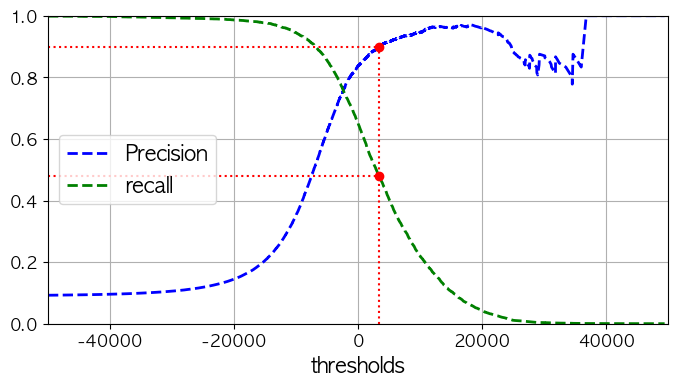

In [55]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

# 정밀도와 재현율 그래프 그리는 함수
def plot_presicion_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'b--',label="Precision",linewidth=2)
    plt.plot(thresholds,recalls[:-1],'g--',label="recall",linewidth=2)
    plt.legend(loc='center left',fontsize=15)
    plt.xlabel("thresholds",fontsize=15)
    plt.grid(True)
    plt.axis([-50000,50000,0,1])
    

plt.figure(figsize=(8,4))
plot_presicion_recall_vs_threshold(precisions,recalls,thresholds)



# 정밀도와 재현율이 0.9 가 되는 위치를 조회
#정밀도가 0.9 가 넘는 데이터 중의 인덱스 구하기 - 선을 그리기 위한 값을 찾기
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                              
plt.show()

In [57]:
# 정밀도가 0.9가 되는 지점을 이용해서 예측
y_train_pred_90=(y_scores>=threshold_90_precision)
# 정밀도 
print(precision_score(y_train_5,y_train_pred_90))
# 재현율
print(recall_score(y_train_5,y_train_pred_90))

0.9000345901072293
0.4799852425751706


#### ROC curve

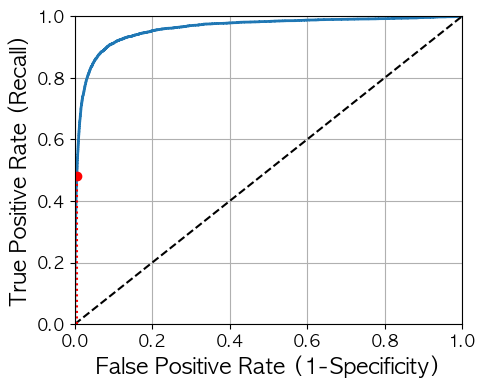

In [59]:
from sklearn.metrics import roc_curve

# 그래프에 사용할 값 계산
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--') # 대각선 그리기 - 완전 랜덤인 경우 
    plt.axis([0, 1, 0, 1])    # 축은 0~1 까지                               
    plt.xlabel('False Positive Rate (1-Specificity)', fontsize=16) # FPR
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)     # TPR
    plt.grid(True)                                            

plt.figure(figsize=(5, 4))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
                                   
plt.show()


In [60]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5,y_scores))

0.9604938554008616


## 다중 분류

### 이진 분류기를 이용한 다중 분류

In [64]:
from sklearn.svm import SVC
# 이진 분류기를 이용해서 0-9 까지의 10개를 분류함. 

svm_clf=SVC(gamma='auto',random_state=42)
svm_clf.fit(X_train[:1000],y_train[:1000])
print(svm_clf.predict([some_digit]))
# 결정 점수를 확인. 그중 가장 높은걸 사용함. -> 5로 판독함. 
some_digit_scores=svm_clf.decision_function([some_digit])
print(some_digit_scores)

[5]
[[ 2.816  7.092  3.83   0.794  5.889  9.297  1.799  8.104 -0.228  4.838]]


### SGD Classifer

In [65]:
sgd_clf.fit(X_train,y_train)
# 예측
print(sgd_clf.predict([some_digit]))
# 결정 점수 확인
print(sgd_clf.decision_function([some_digit]))

[3]
[[-31893.031 -34419.691  -9530.64    1823.732 -22320.148  -1385.805
  -26188.911 -16147.513  -4604.355 -12050.767]]


In [66]:
# 교차 검증을 이용한 정확도 확인
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.874, 0.858, 0.869])

In [67]:
 # 특성이 여러개이고 이 특성의 값이 분포가 일정하지 않은 경우 scailing 이나 standardization 을 고려해야한다. 
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
# 교차 검증을 이용한 정확도 확인
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.898, 0.891, 0.902])

In [71]:
# 오차 행렬 출력.
y_train_predict=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mat=confusion_matrix(y_train,y_train_predict)
print(conf_mat)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


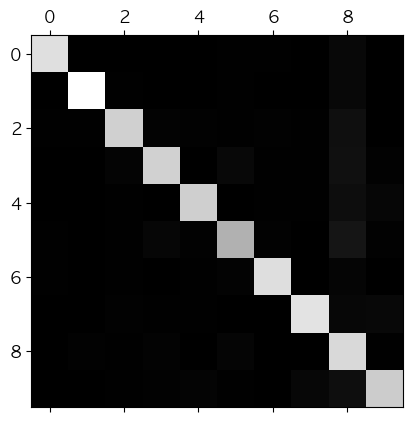

In [74]:
# 오차 행렬을 시각화
plt.matshow(conf_mat,cmap=plt.cm.gray)
plt.show()

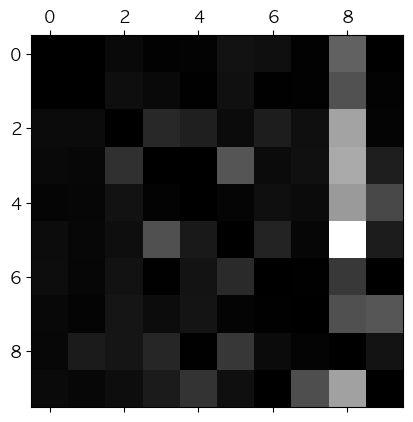

In [75]:
# 오차 행렬을 각 행의 합계로 나누고 대각선을 0으로 채워서 오류를 조금 더 눈에 띄게 출력.

# 분류 모델에서는 이 행렬을 반드시 출력해보는것이 좋다. 
# 잘못 분류된 모델을 확인해 볼 수 있다. 
row_sums=conf_mat.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mat/row_sums
# 주 대각선 방향을 0으로 채움
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

### 다중 레이블 분류

In [76]:
# 출력해야할 레이블이 여러개인 경우
# 이미지를 가지고 7보다 큰지 그리고 홀수인지 여부를 가이 리턴해야하는 경우. 
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
# 2개를 가지고 multilabel 을 생성
y_multilable=np.c_[y_train_large,y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilable) # 타겟값이 2개기 때문에 둘다 판단한다.
knn_clf.predict([some_digit])

array([[False,  True]])

## 분류 알고리즘

### LDA ( 선형 판별 분석 )

In [80]:
# borrowscore 와 payment_inc_ratio 에 따른 outcome 선형 판별 분석
loan3000=pd.read_csv('./python_machine_learning/data/loan3000.csv')
loan3000

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320
...,...,...,...,...,...,...
2995,36589,paid off,debt_consolidation,13.30,0.50,18.36620
2996,43889,paid off,other,6.09,0.60,1.80421
2997,7219,default,debt_consolidation,16.13,0.20,15.42180
2998,8987,default,debt_consolidation,18.39,0.45,8.92335


In [84]:
# 타겟을 범주형으로 변환
loan3000.outcome=loan3000.outcome.astype("category") 

print(loan3000.corr())
# 독립 변수와 종속 변수를 설정.
predictors=['borrower_score','payment_inc_ratio']
outcome='outcome'

# 독립변수 - feature
X=loan3000[predictors]
# 종속 변수 - target
y=loan3000[outcome]

print(X)
print(y)

                   Unnamed: 0       dti  borrower_score  payment_inc_ratio
Unnamed: 0           1.000000 -0.095606        0.249030          -0.102143
dti                 -0.095606  1.000000       -0.258860           0.232972
borrower_score       0.249030 -0.258860        1.000000          -0.109575
payment_inc_ratio   -0.102143  0.232972       -0.109575           1.000000
      borrower_score  payment_inc_ratio
0               0.40            5.11135
1               0.40            5.43165
2               0.70            9.23003
3               0.40            2.33482
4               0.45           12.10320
...              ...                ...
2995            0.50           18.36620
2996            0.60            1.80421
2997            0.20           15.42180
2998            0.45            8.92335
2999            0.40           12.88190

[3000 rows x 2 columns]
0       paid off
1        default
2       paid off
3       paid off
4        default
          ...   
2995    paid off
2

/var/folders/jv/jrhq9b3j1r71dg847_hrmn_m0000gn/T/ipykernel_83389/2882849594.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(loan3000.corr())


In [86]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

loan_lda=LinearDiscriminantAnalysis()
loan_lda.fit(X,y)
# 최적의 값을 확인
print(pd.DataFrame(loan_lda.scalings_,index=X.columns)) # 경계 값을 나타냄. paid-off, default 의 경계선. 

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [91]:
# 처음 5개의 데이터 판별
pred=pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),columns=loan_lda.classes_) # 확률이 나옴
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


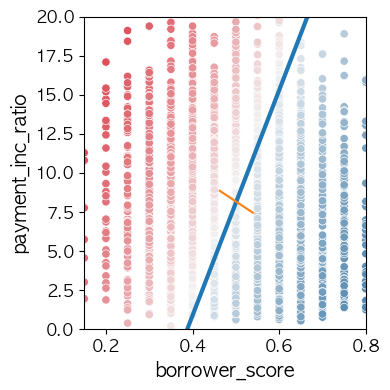

In [92]:
#그래프 그리기 - 대각선의 왼쪽은 default 반대쪽은 paid off
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope
# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope
lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
hue='default', data=lda_df,
palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
ax=ax, legend=False)
ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())
plt.tight_layout()
plt.show()

### KNN 알고리즘을 이용한 분류

In [96]:
# loan 200.csv 파일을 읽어서 payment_Inc_ratio 와 dti 를 이용해서 outcome을 예측
from sklearn.neighbors import KNeighborsClassifier

loan200=pd.read_csv('./python_machine_learning/data/loan200.csv')
predictors=['payment_inc_ratio','dti']
outcome='outcome'

newloan=loan200.loc[0:0,predictors]
X=loan200.loc[1:,predictors]
y=loan200.loc[1:,outcome]

,payment_inc_ratio,dti
0,9.0,22.5


In [99]:
knn=KNeighborsClassifier(n_neighbors=20)

knn.fit(X,y)
print(knn.predict_proba(newloan))
knn.predict(newloan)

[[0.45 0.55]]


array(['paid off'], dtype=object)

#### 표준화 수행한 경우 차이

In [111]:
loan_data = pd.read_csv('./python_machine_learning/data/loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],
categories=['paid off', 'default'],
ordered=True)
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
newloan = loan_data.loc[0:0, predictors]


X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

# 표준화를 하지 않으면 특정 특성이 영향을 많이 미치게 된다.
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [112]:
# 정규화를 수행한 후 이웃 구하기
from sklearn import preprocessing
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]
scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)
X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0) # 정수를 실수로 만들기 위해.

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

# 이전에 비해 revol_bal 을 제외한 속성으 거리들이 가까워졌다
nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


### Logistic Regression

* iris data - virginica 인지 아닌지 판별

In [114]:
from sklearn import datasets
iris=datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [115]:
# feature 생성
X=iris['data'][:,3:] # 3번째 속성 이후꺼만
y=(iris['target']==2).astype(np.uint8) # virginica만 target
print(X,y)

[[0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.4]
 [0.3]
 [0.2]
 [0.2]
 [0.1]
 [0.2]
 [0.2]
 [0.1]
 [0.1]
 [0.2]
 [0.4]
 [0.4]
 [0.3]
 [0.3]
 [0.3]
 [0.2]
 [0.4]
 [0.2]
 [0.5]
 [0.2]
 [0.2]
 [0.4]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.4]
 [0.1]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.1]
 [0.2]
 [0.2]
 [0.3]
 [0.3]
 [0.2]
 [0.6]
 [0.4]
 [0.3]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [1.4]
 [1.5]
 [1.5]
 [1.3]
 [1.5]
 [1.3]
 [1.6]
 [1. ]
 [1.3]
 [1.4]
 [1. ]
 [1.5]
 [1. ]
 [1.4]
 [1.3]
 [1.4]
 [1.5]
 [1. ]
 [1.5]
 [1.1]
 [1.8]
 [1.3]
 [1.5]
 [1.2]
 [1.3]
 [1.4]
 [1.4]
 [1.7]
 [1.5]
 [1. ]
 [1.1]
 [1. ]
 [1.2]
 [1.6]
 [1.5]
 [1.6]
 [1.5]
 [1.3]
 [1.3]
 [1.3]
 [1.2]
 [1.4]
 [1.2]
 [1. ]
 [1.3]
 [1.2]
 [1.3]
 [1.3]
 [1.1]
 [1.3]
 [2.5]
 [1.9]
 [2.1]
 [1.8]
 [2.2]
 [2.1]
 [1.7]
 [1.8]
 [1.8]
 [2.5]
 [2. ]
 [1.9]
 [2.1]
 [2. ]
 [2.4]
 [2.3]
 [1.8]
 [2.2]
 [2.3]
 [1.5]
 [2.3]
 [2. ]
 [2. ]
 [1.8]
 [2.1]
 [1.8]
 [1.8]
 [1.8]
 [2.1]
 [1.6]
 [1.9]
 [2. ]
 [2.2]
 [1.5]
 [1.4]
 [2.3]
 [2.4]
 [1.8]
 [1.8]
 [2.1]
 [2.4]
 [2.3]
 [1.9]

In [116]:
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression(solver="lbfgs",random_state=42)

log_reg.fit(X,y)

LogisticRegression(random_state=42)

In [118]:
# 샘플 데이터 1000개로 예측 진행.
X_new=np.linspace(0,3,1000).reshape(-1,1) # 1차원 배열 만들기. 
# 각 샘플의 확률을 계산
y_proba=log_reg.predict_proba(X_new) 
# 경계 점수
decision_boundary=X_new[y_proba[:,1]>=0.5][0]
print(decision_boundary)# 꽃잎의 길이 1.661 을 기준으로 나눠짐. 

[1.661]
